In [8]:
import torch
from models import HydraNet
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
hydranet = HydraNet()

if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()

In [10]:
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()

ckpt = torch.load('ExpKITTI_joint.ckpt')
hydranet.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [11]:
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

CMAP = np.load('cmap_kitti.npy')
NUM_CLASSES = 6

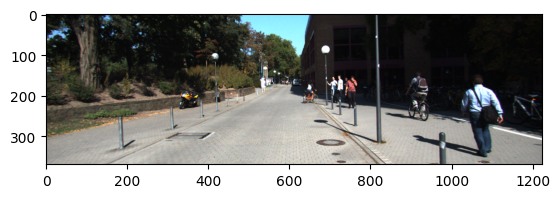

In [12]:
import glob
images_files = glob.glob('data/*.png')
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [13]:
def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        segm, depth = hydranet(img_var)
        segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth = np.abs(depth)
        return depth, segm

In [14]:
depth, segm = pipeline(img)

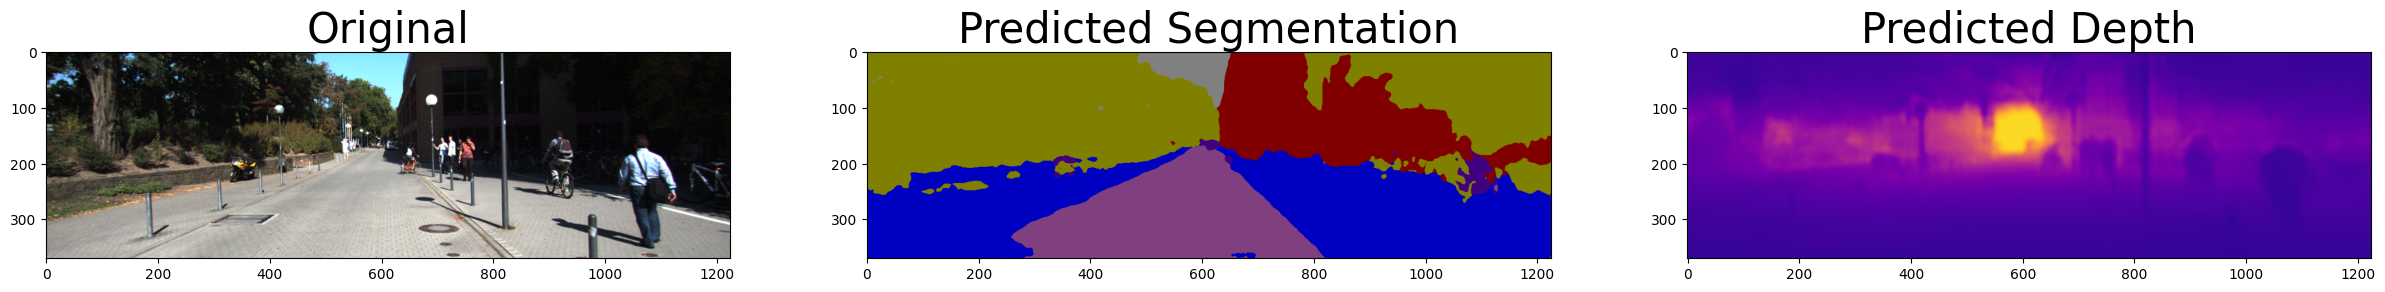

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()

In [16]:
print(img.shape)
print(depth.shape)
print(segm.shape)

(370, 1224, 3)
(370, 1224)
(370, 1224, 3)


(370, 1224, 3)


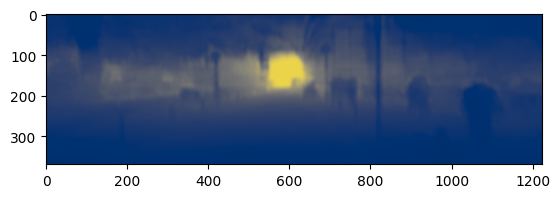

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as co

def depth_to_rgb(depth):
    normalizer = co.Normalize(vmin=0, vmax=80)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='cividis')
    colormapped_im = (mapper.to_rgba(depth)[:, :, :3] * 255).astype(np.uint8)
    return colormapped_im

depth_rgb = depth_to_rgb(depth)
print(depth_rgb.shape)
plt.imshow(depth_rgb)
plt.show()

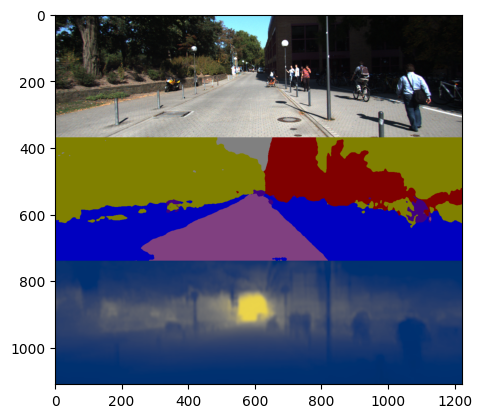

In [18]:
new_img = np.vstack((img, segm, depth_rgb))
plt.imshow(new_img)
plt.show()

In [19]:
video_files = sorted(glob.glob("data/*.png"))

# Build a HydraNet
hydranet = HydraNet()
hydranet.define_mobilenet()
hydranet.define_lightweight_refinenet()

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()

# Load the Weights
ckpt = torch.load('ExpKITTI_joint.ckpt')
hydranet.load_state_dict(ckpt['state_dict'])

# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape
    depth, seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg, depth_to_rgb(depth)]), cv2.COLOR_BGR2RGB))

out = cv2.VideoWriter('output/out.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,3*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

In [20]:
import open3d as o3d

In [21]:
o3d.__version__

'0.18.0'

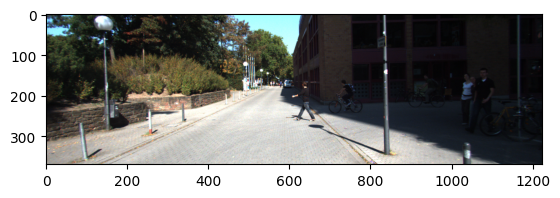

In [23]:
img = Image.open(img_path).convert("RGB")
plt.imshow(img)

In [24]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.io.read_image(img_path),o3d.geometry.Image(depth),convert_rgb_to_intensity=False)

In [ ]:
r

In [25]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(width = 1242, height = 375, fx = 721., fy = 721., cx = 609., cy = 609.)

In [26]:
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
o3d.io.write_point_cloud("test.pcd", point_cloud)

True

In [27]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(segm),o3d.geometry.Image(depth),convert_rgb_to_intensity=False)

In [28]:
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

In [29]:
o3d.io.write_point_cloud("test_segm.pcd", point_cloud)

True

In [30]:
import numpy as np

In [31]:
pcd = o3d.io.read_point_cloud(r"C:\Users\kagad\Vishal\hydranets\test_segm.pcd")
#print(np.array(pcd.points))
o3d.visualization.draw_geometries([pcd])